In [8]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time

### 1. Data Loading and Preprocessing
First, we load the dataset from the `data` subfolder. The data needs to be grouped by transaction and then one-hot encoded for analysis.

In [18]:
# Load the dataset. Note the path assumes the notebook is in the 'notebooks' folder.
df = pd.read_csv('data/Groceries_dataset.csv')

# Group items by transaction (defined by Member_number and Date)
transactions_df = df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index(name='items')
transactions = transactions_df['items'].tolist()

# One-hot encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("One-Hot Encoded DataFrame Head:")
df_encoded.head()

One-Hot Encoded DataFrame Head:


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 2. Exploratory Data Analysis (EDA)
Let's find out which items are most frequently purchased to understand customer preferences.

/var/folders/85/3dnh9sk121s941tzzvm26rj80000gn/T/ipykernel_46637/2057972169.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_items.values, y=top_20_items.index, palette='viridis')


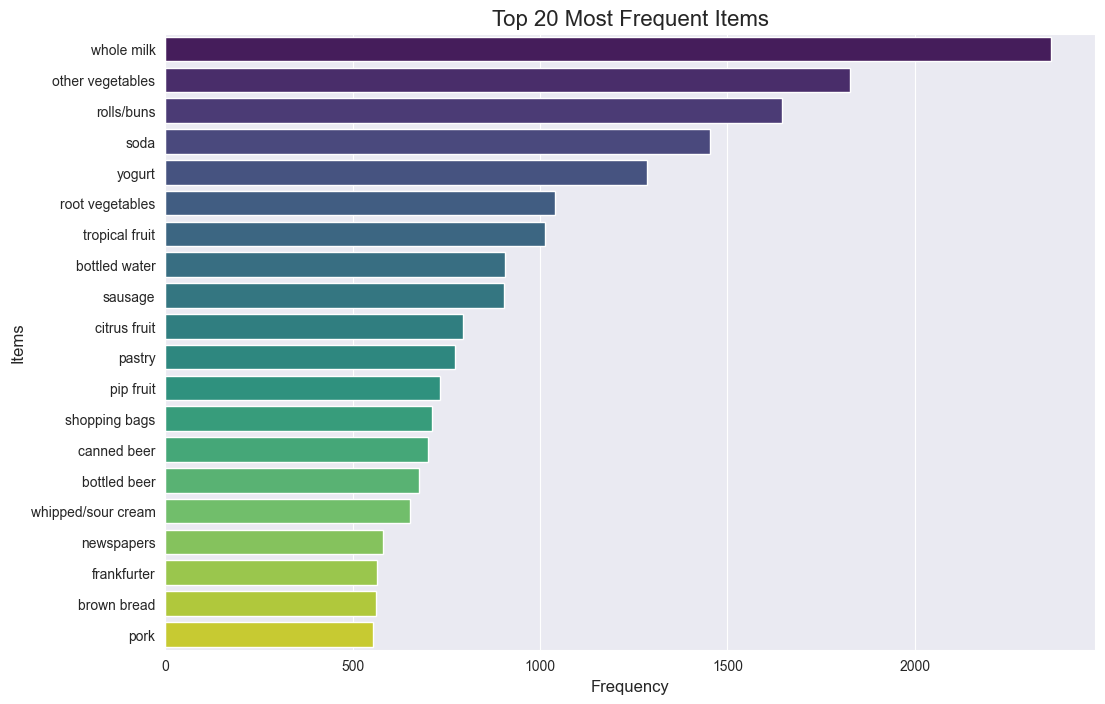

In [19]:
# Count the frequency of each item
item_counts = df_encoded.sum().sort_values(ascending=False)

# Get the top 20 most frequent items
top_20_items = item_counts.head(20)

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_items.values, y=top_20_items.index, palette='viridis')
plt.title('Top 20 Most Frequent Items', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Items', fontsize=12)
plt.show()

### 3. Frequent Itemset Mining & Performance Comparison

**Correction:** To find more granular itemsets, the `min_support` threshold is lowered to `0.001` (0.1%). This allows the algorithm to consider items that appear in at least 15 transactions.

In [20]:
# Lowering the support threshold to find more detailed patterns
min_support_threshold = 0.001

# --- Apriori ---
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(df_encoded, min_support=min_support_threshold, use_colnames=True)
apriori_duration = time.time() - start_time_apriori

# --- FP-Growth ---
start_time_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=min_support_threshold, use_colnames=True)
fpgrowth_duration = time.time() - start_time_fpgrowth

# --- Comparison ---
print("--- Algorithm Performance Comparison ---")
print(f"Number of frequent itemsets found: {len(frequent_itemsets_apriori)}")
print(f"Time taken for Apriori: {apriori_duration:.4f} seconds")
print(f"Time taken for FP-Growth: {fpgrowth_duration:.4f} seconds")
print("-" * 30)

if apriori_duration < fpgrowth_duration:
    print(f"Conclusion: Apriori was faster by {fpgrowth_duration - apriori_duration:.4f} seconds.")
else:
    print(f"Conclusion: FP-Growth was faster by {apriori_duration - fpgrowth_duration:.4f} seconds. With more itemsets to consider, its efficiency becomes more apparent.")

print("\nTop 10 Frequent Itemsets (from FP-Growth):")
frequent_itemsets_fpgrowth.sort_values(by="support", ascending=False).head(10)

--- Algorithm Performance Comparison ---
Number of frequent itemsets found: 750
Time taken for Apriori: 1.2638 seconds
Time taken for FP-Growth: 9.6884 seconds
------------------------------
Conclusion: Apriori was faster by 8.4246 seconds.

Top 10 Frequent Itemsets (from FP-Growth):


,support,itemsets
0,0.157923,(whole milk)
17,0.122101,(other vegetables)
13,0.110005,(rolls/buns)
9,0.097106,(soda)
1,0.085879,(yogurt)
24,0.069572,(root vegetables)
20,0.067767,(tropical fruit)
37,0.060683,(bottled water)
2,0.060349,(sausage)
64,0.053131,(citrus fruit)


### 4. Generating and Analyzing Association Rules

Now, with a richer pool of frequent itemsets, we can generate association rules. We will filter for rules that have a **`lift` greater than 1**, indicating a positive correlation between the items.

In [21]:
# Generate rules using a lift threshold of 1 to find positively correlated items.
rules = association_rules(frequent_itemsets_fpgrowth, metric="lift", min_threshold=1.0)

# Sort the rules by lift and confidence to find the strongest ones
strong_rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])

print(f"\n--- Found {len(strong_rules)} Strong Association Rules (filtered by lift > 1.0) ---")
strong_rules.head(10)


--- Found 240 Strong Association Rules (filtered by lift > 1.0) ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
11,"(yogurt, whole milk)",(sausage),0.011161,0.060349,0.001470,0.131737,2.182917,1.0,0.000797,1.082219,0.548014,0.020992,0.075973,0.078050
14,(sausage),"(yogurt, whole milk)",0.060349,0.011161,0.001470,0.024363,2.182917,1.0,0.000797,1.013532,0.576701,0.020992,0.013351,0.078050
12,"(sausage, whole milk)",(yogurt),0.008955,0.085879,0.001470,0.164179,1.911760,1.0,0.000701,1.093681,0.481231,0.015748,0.085657,0.090650
13,(yogurt),"(sausage, whole milk)",0.085879,0.008955,0.001470,0.017121,1.911760,1.0,0.000701,1.008307,0.521727,0.015748,0.008239,0.090650
94,(specialty chocolate),(citrus fruit),0.015973,0.053131,0.001403,0.087866,1.653762,1.0,0.000555,1.038081,0.401735,0.020731,0.036684,0.057141
95,(citrus fruit),(specialty chocolate),0.053131,0.015973,0.001403,0.026415,1.653762,1.0,0.000555,1.010726,0.417500,0.020731,0.010612,0.057141
10,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,1.0,0.000563,1.131541,0.384877,0.009065,0.116250,0.132562
15,(whole milk),"(yogurt, sausage)",0.157923,0.005748,0.001470,0.009310,1.619866,1.0,0.000563,1.003596,0.454430,0.009065,0.003583,0.132562
134,(tropical fruit),(flour),0.067767,0.009757,0.001069,0.015779,1.617141,1.0,0.000408,1.006118,0.409366,0.013986,0.006081,0.062684
135,(flour),(tropical fruit),0.009757,0.067767,0.001069,0.109589,1.617141,1.0,0.000408,1.046969,0.385385,0.013986,0.044862,0.062684


### 5. Deriving Actionable Business Insights

The final step is to translate these statistical rules into concrete business strategies. Let's analyze the top-ranked rule.

In [22]:
if not strong_rules.empty:
    # Extract the top rule for a concrete example
    top_rule = strong_rules.iloc[0]
    antecedents = ', '.join(list(top_rule['antecedents']))
    consequents = ', '.join(list(top_rule['consequents']))

    print("--- Actionable Insights for the Top Rule ---")

    insight = f"""
    1. Insight from Top Rule: '{{{antecedents}}}' -> '{{{consequents}}}'
       - This rule has a Lift of {top_rule['lift']:.2f}, meaning customers are {top_rule['lift']:.2f} times more likely to buy '{consequents}' if they've already picked up '{antecedents}'.
       - The Confidence is {top_rule['confidence']:.2f}, so about {top_rule['confidence']:.0%} of customers who buy '{antecedents}' also buy '{consequents}'.

    2. Actionable Strategy:
       - Store Layout: Place the '{consequents}' section (e.g., leafy greens, peppers) immediately next to the '{antecedents}' section (e.g., carrots, potatoes). This makes it intuitive for customers to grab both for common recipes.
       - Marketing & Cross-Promotion: Create recipe cards for dishes like stews, soups, or roasted vegetables that require both item types. Place these recipe cards in the produce aisle to inspire customers and increase the total transaction value.
       - Bundling: Offer a "Hearty Stew Pack" or "Roast Dinner Kit" that bundles these vegetables with other related items like beef stock or herbs.
    """
    print(insight)
else:
    print("No strong rules were found with the current settings. Try adjusting the thresholds in the previous cells.")

--- Actionable Insights for the Top Rule ---

    1. Insight from Top Rule: '{yogurt, whole milk}' -> '{sausage}'
       - This rule has a Lift of 2.18, meaning customers are 2.18 times more likely to buy 'sausage' if they've already picked up 'yogurt, whole milk'.
       - The Confidence is 0.13, so about 13% of customers who buy 'yogurt, whole milk' also buy 'sausage'.

    2. Actionable Strategy:
       - Store Layout: Place the 'sausage' section (e.g., leafy greens, peppers) immediately next to the 'yogurt, whole milk' section (e.g., carrots, potatoes). This makes it intuitive for customers to grab both for common recipes.
       - Marketing & Cross-Promotion: Create recipe cards for dishes like stews, soups, or roasted vegetables that require both item types. Place these recipe cards in the produce aisle to inspire customers and increase the total transaction value.
       - Bundling: Offer a "Hearty Stew Pack" or "Roast Dinner Kit" that bundles these vegetables with other related